# When to plan my kite/surf trip to Washington's West Coast

Here I'll look at the average wind conditions to determine when I'll have the best chance of finding good kiting winds.

While model climatologies exist for the region, observations are more accurate and available. Here we will use 
- Station WPTW1 - 9441102 - Westport, WA for our wind conditions [link](https://www.ndbc.noaa.gov/station_history.php?station=wptw1)
- Grays Harbor - for our wave conditions

NOAA API, https://api.tidesandcurrents.noaa.gov/api/prod/#products

Measure of goodness. The ideal kite-day 
- has 4+ hours of wind consistently between 15-20 mph during daylight hours. 
- gusts are minimal, and the variance in wind speed is low.
- Direction is cross-shore. For surfing goofy, direction is from S

Metrics
- daytime: constrained to 8a-7p PDT (Use -7 hours from GMT)
- speed bins: (10-15, 15-20, 20-25, 25+) mph
- 
- Gustiness
- Daily wind variance
- hours wind speed in range (10-15, 15-20, 20-25, 25+)

Plots
- Year-over-Year wind speeds for a given month

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Non-standard library for NOAA API
import noaa_coops as nc
from calendar import monthrange

In [5]:
def number_of_days_in_month(year=2019, month=2):
    return monthrange(year, month)[1]

import datetime
import calendar

def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.datetime(year, month, day)

In [10]:
%%time
# 5 minutes to download

refresh = False
if refresh:
    west_port = nc.Station('9441102')
    wind = west_port.get_data(
        begin_date="20080101",
        end_date="20220101",
        product="wind",
        bin_num=2,
        units="metric",
        time_zone="gmt",
    )
    # Save for faster loading
    fname = '../offline_data/west_port_winds.h5'
    wind.to_hdf(fname, key='wind', mode='w')  
else:
    fname = '../offline_data/west_port_winds.h5'
    wind = pd.read_hdf(fname)
    
# Convert to mph    
wind['spd'] = wind['spd']*2.23694
wind['gust_spd'] = wind['gust_spd']*2.23694    

CPU times: user 371 ms, sys: 108 ms, total: 478 ms
Wall time: 497 ms


In [13]:
np.max(wind.spd)

56.147194000000006

In [15]:
# Wow, 6-min data
wind.head(10)

,spd,dir,compass,gust_spd,flags
date_time,,,,,
2008-06-04 00:00:00,NaN,NaN,,NaN,"1,1"
2008-06-04 00:06:00,NaN,NaN,,NaN,"1,1"
2008-06-04 00:12:00,NaN,NaN,,NaN,"1,1"
2008-06-04 00:18:00,NaN,NaN,,NaN,"1,1"
2008-06-04 00:24:00,NaN,NaN,,NaN,"1,1"
2008-06-04 00:30:00,NaN,NaN,,NaN,"1,1"
2008-06-04 00:36:00,NaN,NaN,,NaN,"1,1"
2008-06-04 00:42:00,NaN,NaN,,NaN,"1,1"
2008-06-04 00:48:00,NaN,NaN,,NaN,"1,1"


In [29]:
def calc_speed_distr_by_month(wind, mon, bins, years):
    '''
    Caclulate the hours per day for various wind speed bins (bins) each year for a given month
    '''
    histn = np.zeros((len(bins)-1, len(years)))
    
    for i,y in enumerate(years):
        temp = wind['spd'][(wind.index > datetime.datetime(y,mon,1)) & (wind.index < add_months(datetime.datetime(y,mon,1), 1))]        
        temp = temp[~np.isnan(temp)]
        Ndays = len(temp) / (10*24)
        hist = np.histogram(temp, bins=bins)
        histn[:,i] = hist[0] / 10 / Ndays   
        
    histn = histn.transpose()     
    
    df = pd.DataFrame(histn, columns=bins[1:] , index=years)
    
    return df

bins = np.arange(0,35,2.5)
years = np.arange(2009,2022,1)
df = calc_speed_distr_by_month(wind, mon, bins, years)
for mon in np.arange(1,13):
    df_temp = calc_speed_distr_by_month(wind, mon, bins, years)
    df_temp['month'] = mon
    df = pd.concat((df, df_temp), axis=0)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [31]:
df_temp

,2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0,22.5,25.0,27.5,30.0,32.5,month
2009,1.090163,1.605692,2.275551,3.011082,3.749897,4.370502,3.011082,1.993159,1.346285,0.863593,0.472842,0.170748,0.036120,12
2010,0.206267,0.742562,1.780246,3.579532,4.636255,4.369695,2.694169,2.030940,1.450218,0.869496,0.558509,0.399841,0.241174,12
2011,0.668924,1.938005,3.697838,4.754363,3.788487,2.785100,1.841104,1.500391,1.390987,0.631414,0.478250,0.346965,0.087523,12
2012,0.328724,1.202191,2.595356,3.806940,3.763110,3.064962,2.182103,1.634229,1.631098,1.687451,0.970519,0.547874,0.225411,12
2013,0.524889,2.048034,4.701462,5.329398,4.411646,2.479538,1.436200,1.027237,0.763183,0.540990,0.405743,0.199651,0.080504,12
2014,0.350691,0.892667,1.718385,2.684378,3.867163,4.249734,3.296493,2.206164,1.485654,0.962806,0.720510,0.640808,0.526036,12
2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
2017,0.465686,1.575205,2.231541,2.928506,2.962886,3.284803,3.272301,2.875374,2.172158,1.365803,0.531319,0.206277,0.046881,12
2018,0.545954,1.007190,2.124199,2.983919,3.360439,3.617728,2.864688,2.419140,1.763368,1.277030,0.928749,0.533403,0.310629,12


In [22]:
month_strs = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


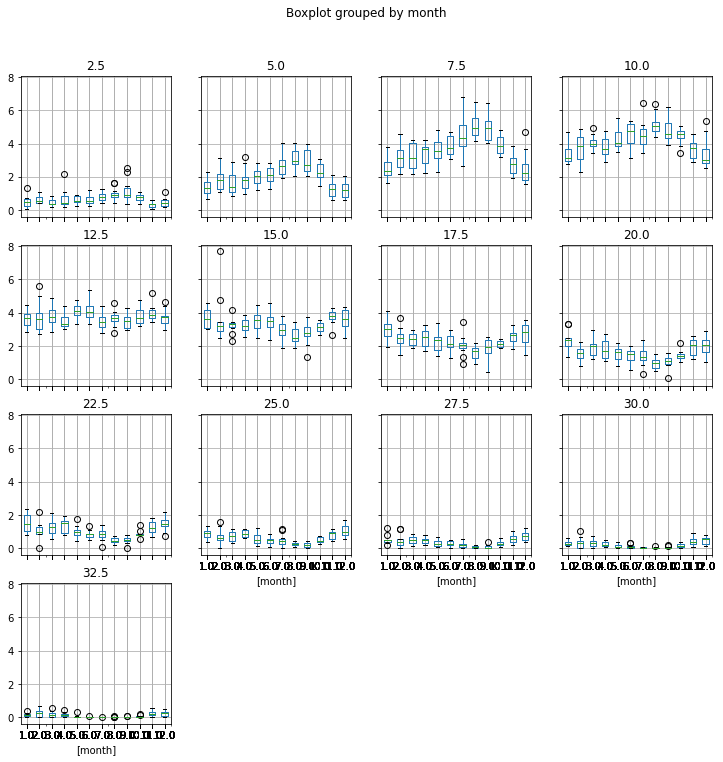

In [23]:

bins = np.arange(0,31,2.5)
years = np.arange(2008, 2022)

mon = 1
#df = calc_speed_distr_by_month(wind, mon, bins, years)
df.boxplot(by='month', figsize=(12,12))

#plt.xlabel('Wind Speed [mph]')    
#plt.ylabel('Average Hours per day')
plt.ylim([0, 7])
plt.show()

In [19]:
def circular_mean(md):
    mdr = np.deg2rad(md)
    u = np.cos(mdr)
    v = np.sin(mdr)
    um = np.mean(u)
    vm = np.mean(v)
    mdm = np.arctan2(vm,um)
    mdm = np.rad2deg(mdm)
    return mdm


In [421]:
%%time
# Improve with: sunset/sunrise calc, proper direct avg, continuous wind, 
# Define if day is kiteable for all days in record, boolean. Then groupby
wind['time_pdt'] = wind.index - datetime.timedelta(hours=7)
days = np.arange(wind.index[0],wind.index[-1], dtype='datetime64[D]')
hours_windy = np.zeros(days.shape)
hours_foil = np.zeros(days.shape)
gust_ratio = np.zeros(days.shape)
mean_dir = np.zeros(days.shape)
wind_std = np.zeros(days.shape)
for i,d in enumerate(days): #[2000:2001]: (for testing)
    morning = d + np.timedelta64(8,'h') #8am
    evening = d + np.timedelta64(19,'h') #7pm   
    I = (wind['time_pdt'] >= morning) & (wind['time_pdt'] <= evening)
    wspd = wind['spd'][I]
    wdir = wind['dir'][I]
    wgst = wind['gust_spd'][I]
    I_windy = (wspd >= 12) & (wspd <= 25) & (wdir > 160) & (wdir < 360)
    hours_windy[i] = np.sum(I_windy) / 10
    if hours_windy[i] > 0:
        hours_foil[i] = np.sum( (wspd >= 8) & (wspd <= 15) & (wdir > 160) & (wdir < 360) ) / 10
        gust_ratio[i] = np.mean( wgst[I_windy] / wspd[I_windy])
        mean_dir[i] = circular_mean(wdir[I_windy])
        wind_std[i] = np.std(wspd[I_windy])
    else:
        gust_ratio[i] = np.nan
        wind_std[i] = np.nan
        mean_dir[i] = np.nan

CPU times: user 55.6 s, sys: 844 ms, total: 56.4 s
Wall time: 59.4 s


In [423]:
dfd = pd.DataFrame({'day':days, 'hours_windy':hours_windy, 
                    'hours_foil':hours_foil, 
                    'gust_ratio':gust_ratio,
                    'mean_dir':mean_dir,
                    'wind_std':wind_std})

In [424]:
dfd['kite'] = (dfd['hours_windy'] > 4)

In [425]:
dfd['month'] = [x.month for x in dfd['day']]

In [426]:
dfd.groupby('month').mean()

,hours_windy,hours_foil,gust_ratio,mean_dir,wind_std,kite
month,,,,,,
1,2.011414,1.245161,1.344319,-69.775743,2.059516,0.225806
2,1.828610,1.301362,1.283863,-76.369473,1.937510,0.185286
3,3.224566,2.306203,1.289087,-84.160229,1.901762,0.347395
4,4.119231,3.055897,1.243161,-80.950282,1.930578,0.474359
5,4.105955,3.774690,1.197946,-69.635125,1.780378,0.478908
6,3.823261,3.815108,1.189421,-71.506308,1.667930,0.434053
7,3.572811,3.082949,1.177436,-56.735104,1.800068,0.403226
8,2.735714,3.425806,1.181416,-66.593845,1.592484,0.311060
9,2.718571,2.690476,1.226306,-76.375655,1.638052,0.354762


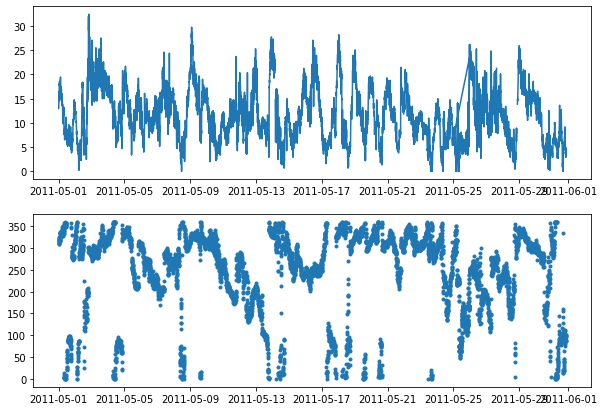

In [368]:
fix, ax = plt.subplots(2,1, figsize=(10,7))
ax[0].plot(wspd_month)
ax[1].plot(wdir_month,'.')

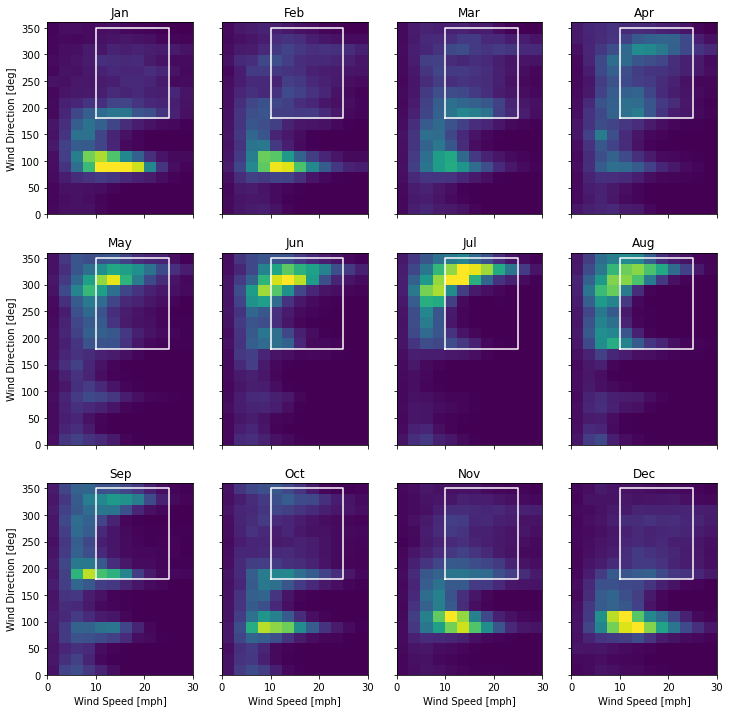

In [427]:
# Probability Distributions
fig, ax = plt.subplots(3, 4, figsize=(12,12), sharex=True, sharey=True)
ax = ax.ravel()

sbins = np.arange(0,32.5,2.5)
dbins = np.arange(0,380,20)
month_strs = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for i in np.arange(12):
    mon = i + 1
    I = wind.index.month == mon
    wspd_month = wind['spd'][I]
    wdir_month = wind['dir'][I]
    plt.sca(ax[i])
    plt.hist2d(wspd_month,wdir_month, bins=(sbins,dbins), density=True)
    plt.title(month_strs[i])
    plt.clim([0, .0008])
    plt.plot([10, 25, 25, 10, 10], [180, 180, 350, 350, 180], 'w')

ax[0].set_ylabel('Wind Direction [deg]')
ax[4].set_ylabel('Wind Direction [deg]')
ax[8].set_ylabel('Wind Direction [deg]')
ax[8].set_xlabel('Wind Speed [mph]')
ax[9].set_xlabel('Wind Speed [mph]')
ax[10].set_xlabel('Wind Speed [mph]')
ax[11].set_xlabel('Wind Speed [mph]')
plt.show()

# Wave analysis

We will look Grays Harbor, just offshore of westport. It is a buoy run by [CDIP](https://cdip.ucsd.edu/themes/cdip?d2=p70&pb=1&u2=p_id:p70:mode:all:s:036:st:1) that measures wave properties such as height and direction. 

Let's determine the number of good days for surfing by these parameters
- Shortboard
    - 3.5-feet < Hs < 8-feet
    - 8-sec < Tp < 24-sec
- Longboard
    - 1.5-feet < Hs < 3.5-feet
    - 8-sec < Tp < 24-sec
- wind speed < 5 mph for directions from 200-340 (onshore)
- wind speed < 10 mph for directions 0-200 or 340-360 (side-shore / offshore)
- Component-wise: Or we could say the onshore component < 2.5mph while the offshore component < 10mph, and side shore components < 5mph

In [15]:
import netCDF4
import datetime
import time

import pandas as pd
from matplotlib import gridspec
from matplotlib import pyplot as plt

In [2]:
%%time

# Grays Harbor
stn = '036'

# CDIP Archived Dataset URL
data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/' + stn + 'p1/' + stn + 'p1_historic.nc'
nc = netCDF4.Dataset(data_url)

CPU times: user 15 ms, sys: 17.6 ms, total: 32.7 ms
Wall time: 366 ms


In [17]:
ncTime = nc.variables['waveTime']
time = [datetime.datetime.fromtimestamp(t) for t in ncTime] # Convert ncTime variable to datetime stamps, 30-min spacing
hs = nc.variables['waveHs'][:] * 3.28 # meters to feet
tp = nc.variables['waveTp'][:]
dp = nc.variables['waveDp'][:]

In [19]:
wave = pd.DataFrame({'hs':hs, 'tp':tp, 'dp':dp, 'time':time})
wave.set_index('time', inplace=True)

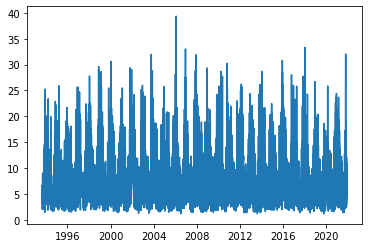

In [21]:
plt.plot(time,hs)

In [34]:
wind_hr = wind.groupby(pd.Grouper(freq='H')).mean()
wave_hr = wave.groupby(pd.Grouper(freq='H')).mean()
wind_wave = wind_hr.merge(wave_hr)

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [447]:
wind_hr

,spd,dir,gust_spd
date_time,,,
2008-06-04 00:00:00,NaN,NaN,NaN
2008-06-04 01:00:00,NaN,NaN,NaN
2008-06-04 02:00:00,NaN,NaN,NaN
2008-06-04 03:00:00,NaN,NaN,NaN
2008-06-04 04:00:00,NaN,NaN,NaN
...,...,...,...
2022-01-01 19:00:00,7.404271,131.3,12.124215
2022-01-01 20:00:00,8.656958,146.4,13.130838
2022-01-01 21:00:00,11.341286,167.2,17.873151


In [33]:
wave_hr

,hs,tp,dp
time,,,
1993-08-27 08:00:00,3.050400,10.526316,288.593750
1993-08-27 09:00:00,2.952000,10.526316,288.593750
1993-08-27 10:00:00,NaN,NaN,NaN
1993-08-27 11:00:00,3.280000,9.876543,282.968750
1993-08-27 12:00:00,3.312800,9.876543,285.781250
...,...,...,...
2021-11-22 20:00:00,11.512800,11.929825,274.750000
2021-11-22 21:00:00,11.594799,13.333333,278.265625
2021-11-22 22:00:00,10.774799,12.500000,276.156250
